In [97]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn
import jax

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from torch.utils.data import DataLoader, TensorDataset

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import corner

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

## Neural network 

In [98]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  
            nn.ReLU(),
            nn.Linear(256, 256),  # 2
            nn.ReLU(),
            nn.Linear(256, 256),  # 3
            nn.ReLU(),
            nn.Linear(256, 256),  # 4
            nn.ReLU(),
            nn.Linear(256, 256),  # 5
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
ckpt_path = "best_model_v8-1-epoch=9965-val_loss=0.0071.ckpt"
input_dim = 7  # Number of input features
output_dim = 5  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  

GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=5, bias=True)
  )
  (criterion): MSELoss()
)

## Importing scaling relations

In [99]:
import joblib

scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

## Extracting data for specific track

In [ ]:
import jax.numpy as jnp

# Plotting for neural network and garstec track: 07298
specific_track_name = 'track01624'

# Retrieve all required inputs for track: 07298
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    age_07298 = specific_track['age'][:].reshape(-1, 1)
    massini_07298 = specific_track['massini'][:].reshape(-1, 1)
    fehini_07298 = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt_07298 = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini_07298 = specific_track['yini'][:].reshape(-1, 1)
    eta_07298 = specific_track['eta'][:].reshape(-1, 1)
    alphafe_07298 = specific_track['alphaFe'][:].reshape(-1, 1)

    # Retrieve actual values for plotting
    teff_07298 = specific_track['Teff'][:]
    luminosity_07298 = specific_track['LPhot'][:]
    dnufit_07298 = specific_track['dnufit'][:]
    FeH_07298 = specific_track['FeH'][:]
    numax_07298 = specific_track['numax'][:]

# Using a single age point from the middle of the ages:

index_07298 = round(len(age_07298)/2)

age_07298_ = age_07298[index_07298]
massini_07298_ = massini_07298[index_07298]
fehini_07298_ = fehini_07298[index_07298]
alphamlt_07298_ = alphamlt_07298[index_07298]
yini_07298_ = yini_07298[index_07298]
eta_07298_ = eta_07298[index_07298]
alphafe_07298_ = alphafe_07298[index_07298]


teff_07298_ = teff_07298[index_07298]
luminosity_07298_ = luminosity_07298[index_07298]
dnufit_07298_ = dnufit_07298[index_07298]
FeH_07298_ = FeH_07298[index_07298]
numax_07298_ = numax_07298[index_07298]



## Emulate function for Bayesian model

In [101]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x

In [102]:
obs_err = {
    'teff_err': [70],
    'lum_err': [5],
    'dnu_err': [0.1],
    'feh_err': [0.1],
    'numax_err': [0.5]
}

teff_obs = teff_07298_ + np.random.randn() * obs_err['teff_err'][0]
lum_obs = luminosity_07298_ + np.random.randn() * obs_err['lum_err'][0]
dnu_obs = dnufit_07298_ + np.random.randn() * obs_err['dnu_err'][0]
FeH_obs = FeH_07298_ + np.random.randn() * obs_err['lum_err'][0]
numax_obs = numax_07298_ * sun_numax + np.random.randn() * obs_err['numax_err'][0]

obs = {
    'teff': [teff_obs],
    'lum': [lum_obs],
    'dnu': [dnu_obs],
    'feh': [FeH_obs],
    'numax': [numax_obs],
}



## Bayesian model

In [121]:
def Bmodel(obs=None):
    # Define priors

    massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 0.7)
    tau_hat = numpyro.deterministic("tau_hat", 4 * numpyro.sample("tau_hat_s", dist.Beta(1.25, 2)) + 1) 

    # Calculate values for joint prior: 
    tau_ms = (2500) * (massini_**-3.15)
    ages_ = numpyro.deterministic("ages_", jnp.minimum(tau_hat * tau_ms, 20000)) # jnp.min to avoid values outside of grid

    # Rest of priors:
    alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 1.5)
    yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.22)
    eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 2)))
    alphafe_ = numpyro.deterministic("alphafe_", 0.8 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.2) 
    fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2)

    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, yini_] 
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.hstack(log_transformed_inputs + [fehini_, alphafe_])


    # Scale x manually
    mean_x = scaler_X.mean_
    scale_x = scaler_X.scale_  
    x_scaled = (x - mean_x) / scale_x

    # Emulate using PyTorch model
    y_scaled = emulate(x_scaled)
    
    # De-scale y manually 
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y

    # Extract predictions
    teff = numpyro.deterministic("teff", jnp.power(10.0, y[..., 0])) 
    lum = numpyro.deterministic("lum", jnp.power(10.0, y[..., 1])) 
    dnu = numpyro.deterministic("dnu", jnp.power(10.0, y[..., 2]))
    numax = numpyro.deterministic("numax", jnp.power(10.0, y[..., 3])) * sun_numax
    feh = numpyro.deterministic("feh", y[..., 4])

    
    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, obs_err['teff_err'][0]), obs=obs['teff'][0])
        numpyro.sample("lum_obs", dist.StudentT(5, lum, obs_err['lum_err'][0]), obs=obs['lum'][0])
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, obs_err['dnu_err'][0]), obs=obs['dnu'][0])
        numpyro.sample("feh_obs", dist.StudentT(5, feh, obs_err['feh_err'][0]), obs=obs['feh'][0])
        numpyro.sample("numax_obs", dist.StudentT(5, numax, obs_err['numax_err'][0]), obs=obs['numax'][0])

## Prior predictive

In [104]:
from numpyro.infer import Predictive

from jax import random

prior_predictive = Predictive(Bmodel, num_samples=1000)
samples = prior_predictive(jax.random.PRNGKey(0))

In [105]:
# fig = corner.corner(samples, var_names=['teff', 'lum', 'dnu', 'feh', 'numax'], show_titles=True)
# plt.show()

In [127]:
from jax import random

nuts_kernel = NUTS(Bmodel)

prior_mcmc = MCMC(nuts_kernel, num_samples=8000, num_warmup=8000)
rng_key = random.PRNGKey(0)
prior_mcmc.run(rng_key, obs=None)

posterior_samples = prior_mcmc.get_samples()

sample: 100%|██████████| 16000/16000 [00:29<00:00, 538.17it/s, 7 steps of size 6.33e-01. acc. prob=0.91] 


c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


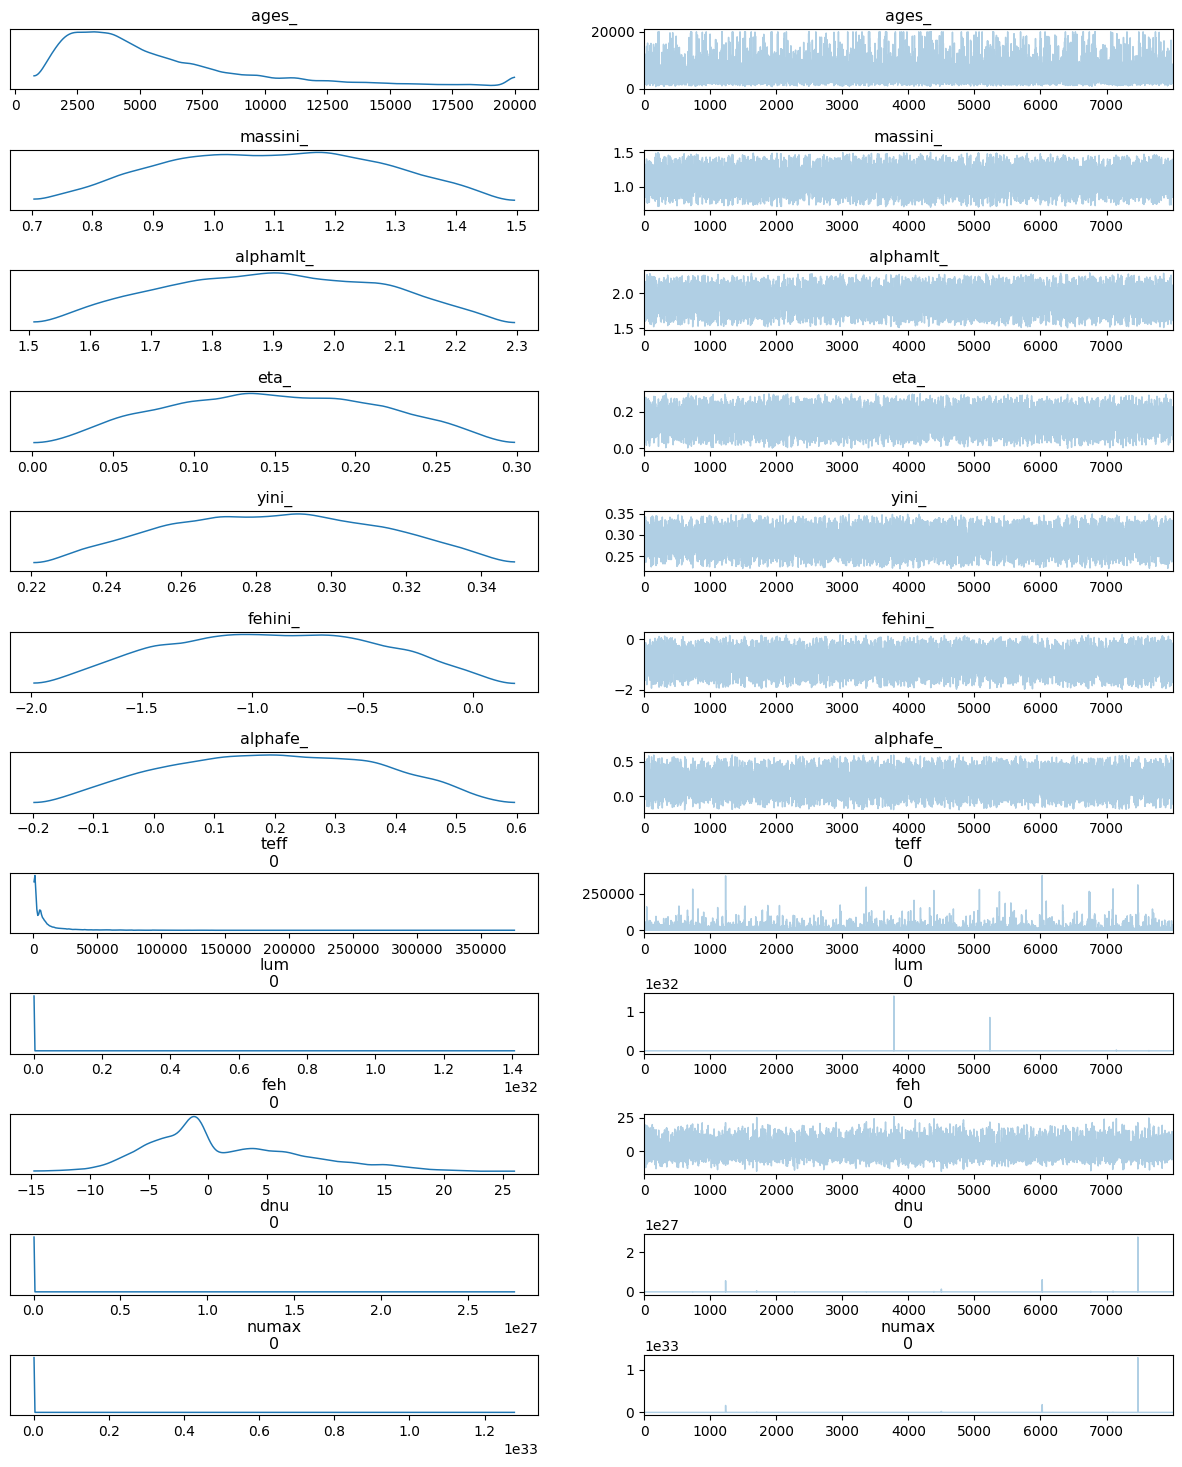

In [128]:
import arviz as az

prior_trace = az.from_numpyro(prior_mcmc)
az.plot_trace(prior_trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_',
                                       'alphafe_', 'teff', 'lum', 'feh', 'dnu', 'numax'], compact=False, figsize=(15, 18));  

plt.subplots_adjust(hspace=1)  

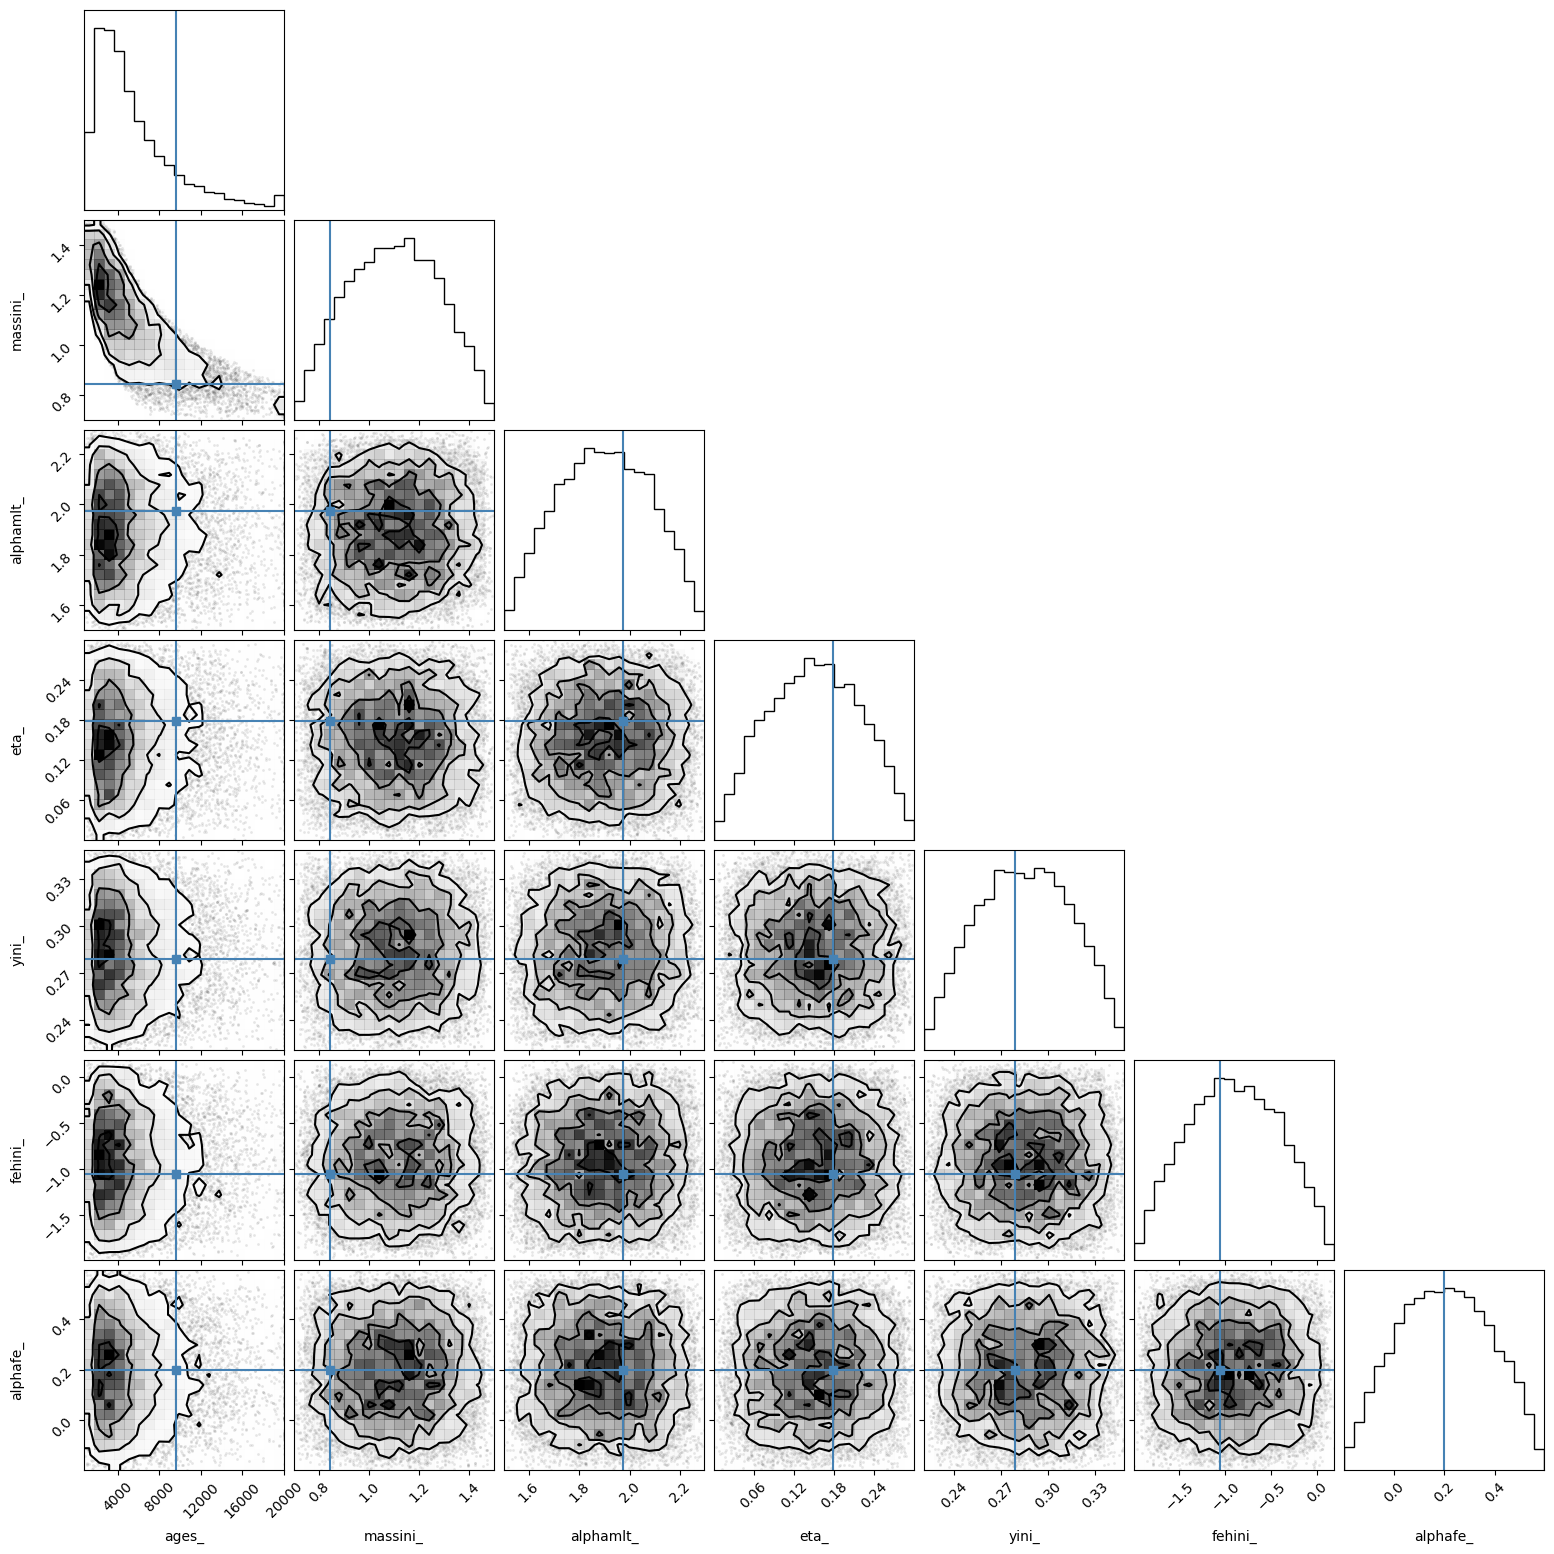

In [124]:
truths_prior = truth_values = [age_07298[0].item(), massini_07298[0].item(),
                                alphamlt_07298[0].item(), eta_07298[0].item(),
                                  yini_07298[0].item(),  fehini_07298[0].item(),
                                    alphafe_07298[0].item()]
#print(truth_values)

corner.corner(prior_trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truths_prior);


## Running model and Posterior plotting 

In [125]:
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=4) # between 1000 and 4000 for testing 
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_59328\1111293535.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=2000, num_samples=2000, num_chains=4) # between 1000 and 4000 for testing
sample: 100%|██████████| 4000/4000 [02:51<00:00, 23.39it/s, 1023 steps of size 9.03e-04. acc. prob=0.53]


In [126]:
trace = az.from_numpyro(mcmc)

az.summary(trace)

mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
ages_       6150.881  1805.478  3124.191  9525.428    560.184  407.796   
alphafe_       0.149     0.184    -0.144     0.473      0.051    0.037   
alphafe_s      0.436     0.230     0.070     0.841      0.064    0.046   
alphamlt_      1.840     0.164     1.551     2.120      0.045    0.033   
alphamlt_s     0.426     0.205     0.064     0.775      0.056    0.041   
dnu[0]         3.731     0.075     3.590     3.874      0.012    0.008   
eta_           0.153     0.071     0.011     0.262      0.021    0.015   
eta_s          0.510     0.235     0.038     0.872      0.068    0.050   
feh[0]        -1.157     0.310    -1.786    -0.649      0.092    0.067   
fehini_       -1.172     0.312    -1.790    -0.643      0.093    0.068   
fehini_s       0.376     0.142     0.096     0.617      0.042    0.032   
lum[0]        65.303     4.830    56.188    74.650      1.161    0.835   
massini_       0.968     0.070     0.849     1.098      0.018    0.013   
massini_s      0.335     0.088     0.186     0.498      0.023    0.017   
numax[0]       0.009     0.000     0.009     0.009      0.000    0.000   
tau_hat        2.136     0.323     1.520     2.667      0.095    0.069   
tau_hat_s      0.284     0.081     0.130     0.417      0.024    0.017   
teff[0]     5033.693    66.543  4915.618  5164.096     11.098    7.912   
yini_          0.284     0.027     0.237     0.336      0.009    0.006   
yini_s         0.495     0.209     0.133     0.895      0.067    0.051   

            ess_bulk  ess_tail  r_hat  
ages_           10.0      40.0   1.30  
alphafe_        14.0      41.0   1.26  
alphafe_s       14.0      41.0   1.26  
alphamlt_       15.0      57.0   1.23  
alphamlt_s      15.0      57.0   1.23  
dnu[0]          42.0     347.0   1.07  
eta_            13.0      32.0   1.28  
eta_s           13.0      32.0   1.28  
feh[0]          12.0      45.0   1.30  
fehini_         12.0      42.0   1.30  
fehini_s        12.0      42.0   1.30  
lum[0]          17.0      37.0   1.16  
massini_        15.0      55.0   1.22  
massini_s       15.0      55.0   1.22  
numax[0]        98.0     770.0   1.03  
tau_hat         12.0      68.0   1.24  
tau_hat_s       12.0      68.0   1.24  
teff[0]         36.0     113.0   1.08  
yini_           11.0      29.0   1.28  
yini_s          11.0      29.0   1.28

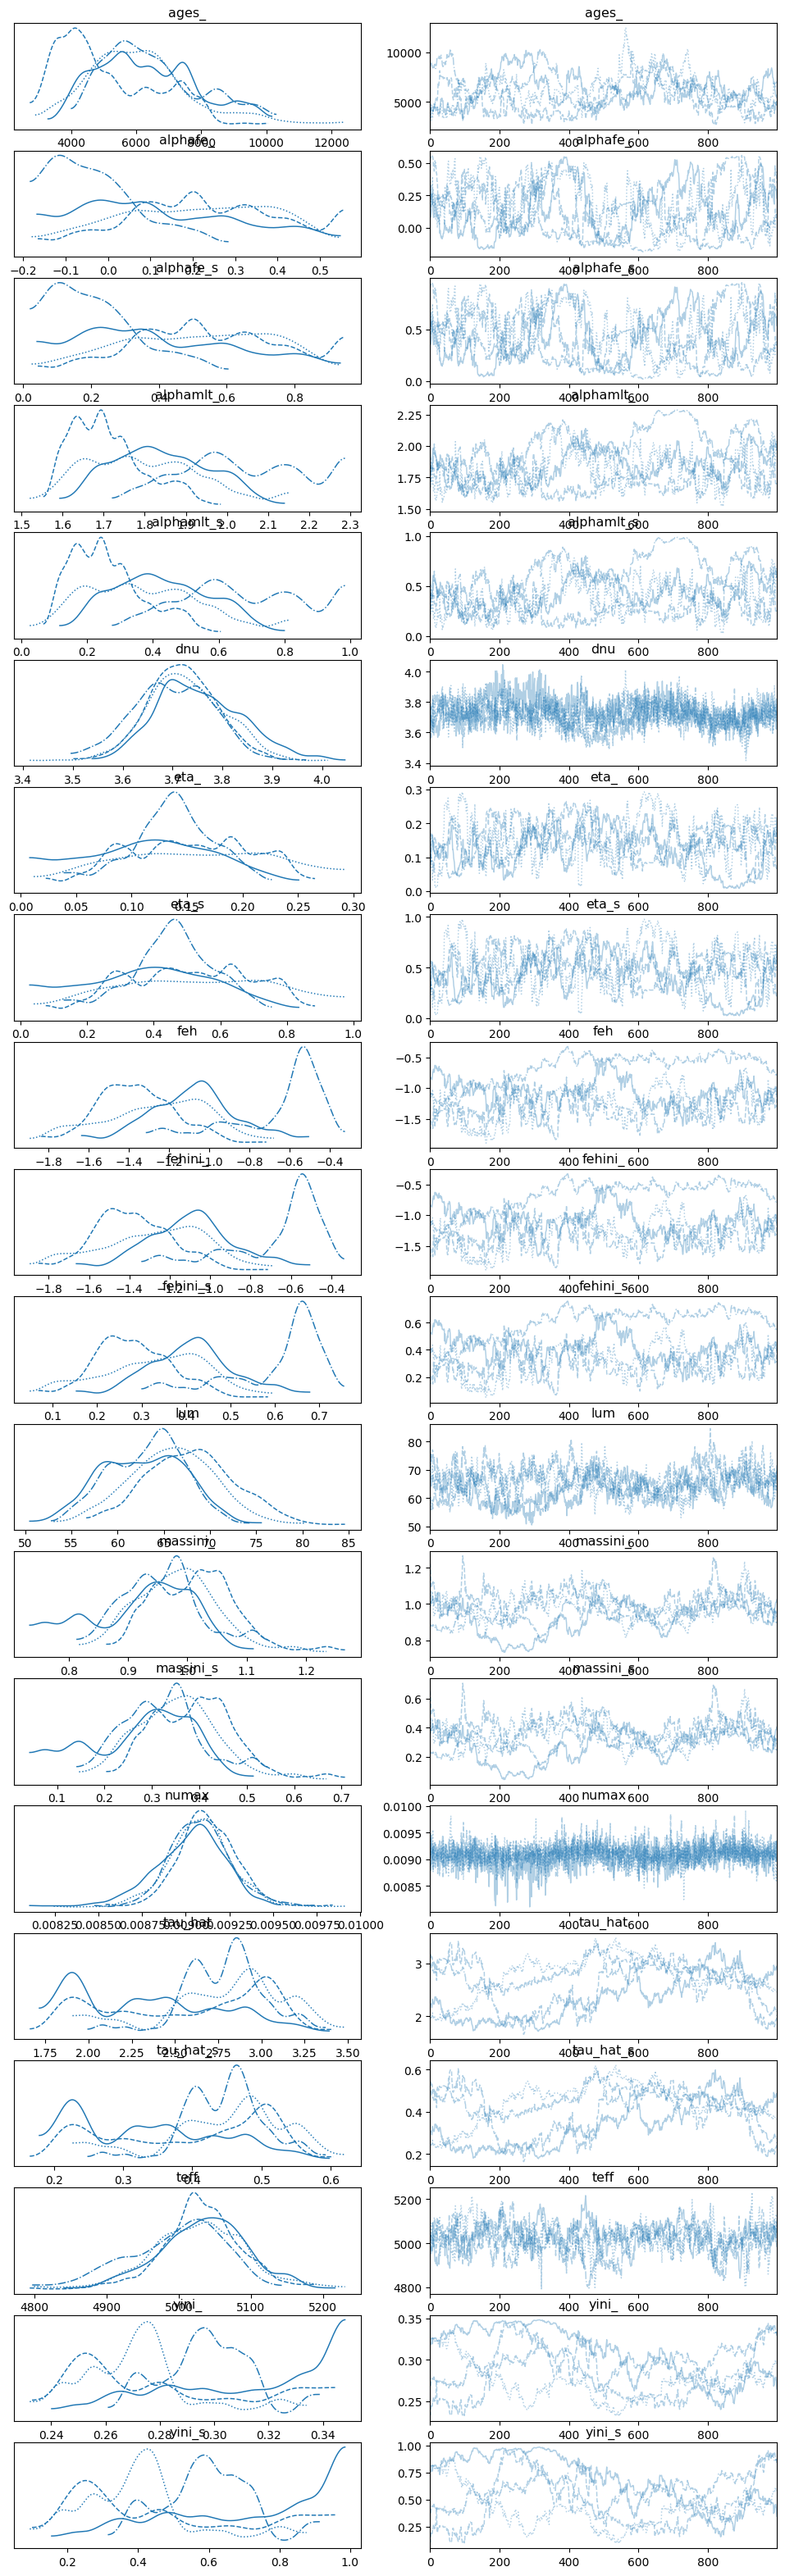

In [111]:
az.plot_trace(trace);

[10018.17118, 0.845, 1.97304687, 0.177978516, 0.27909668, -1.05361328, 0.2]


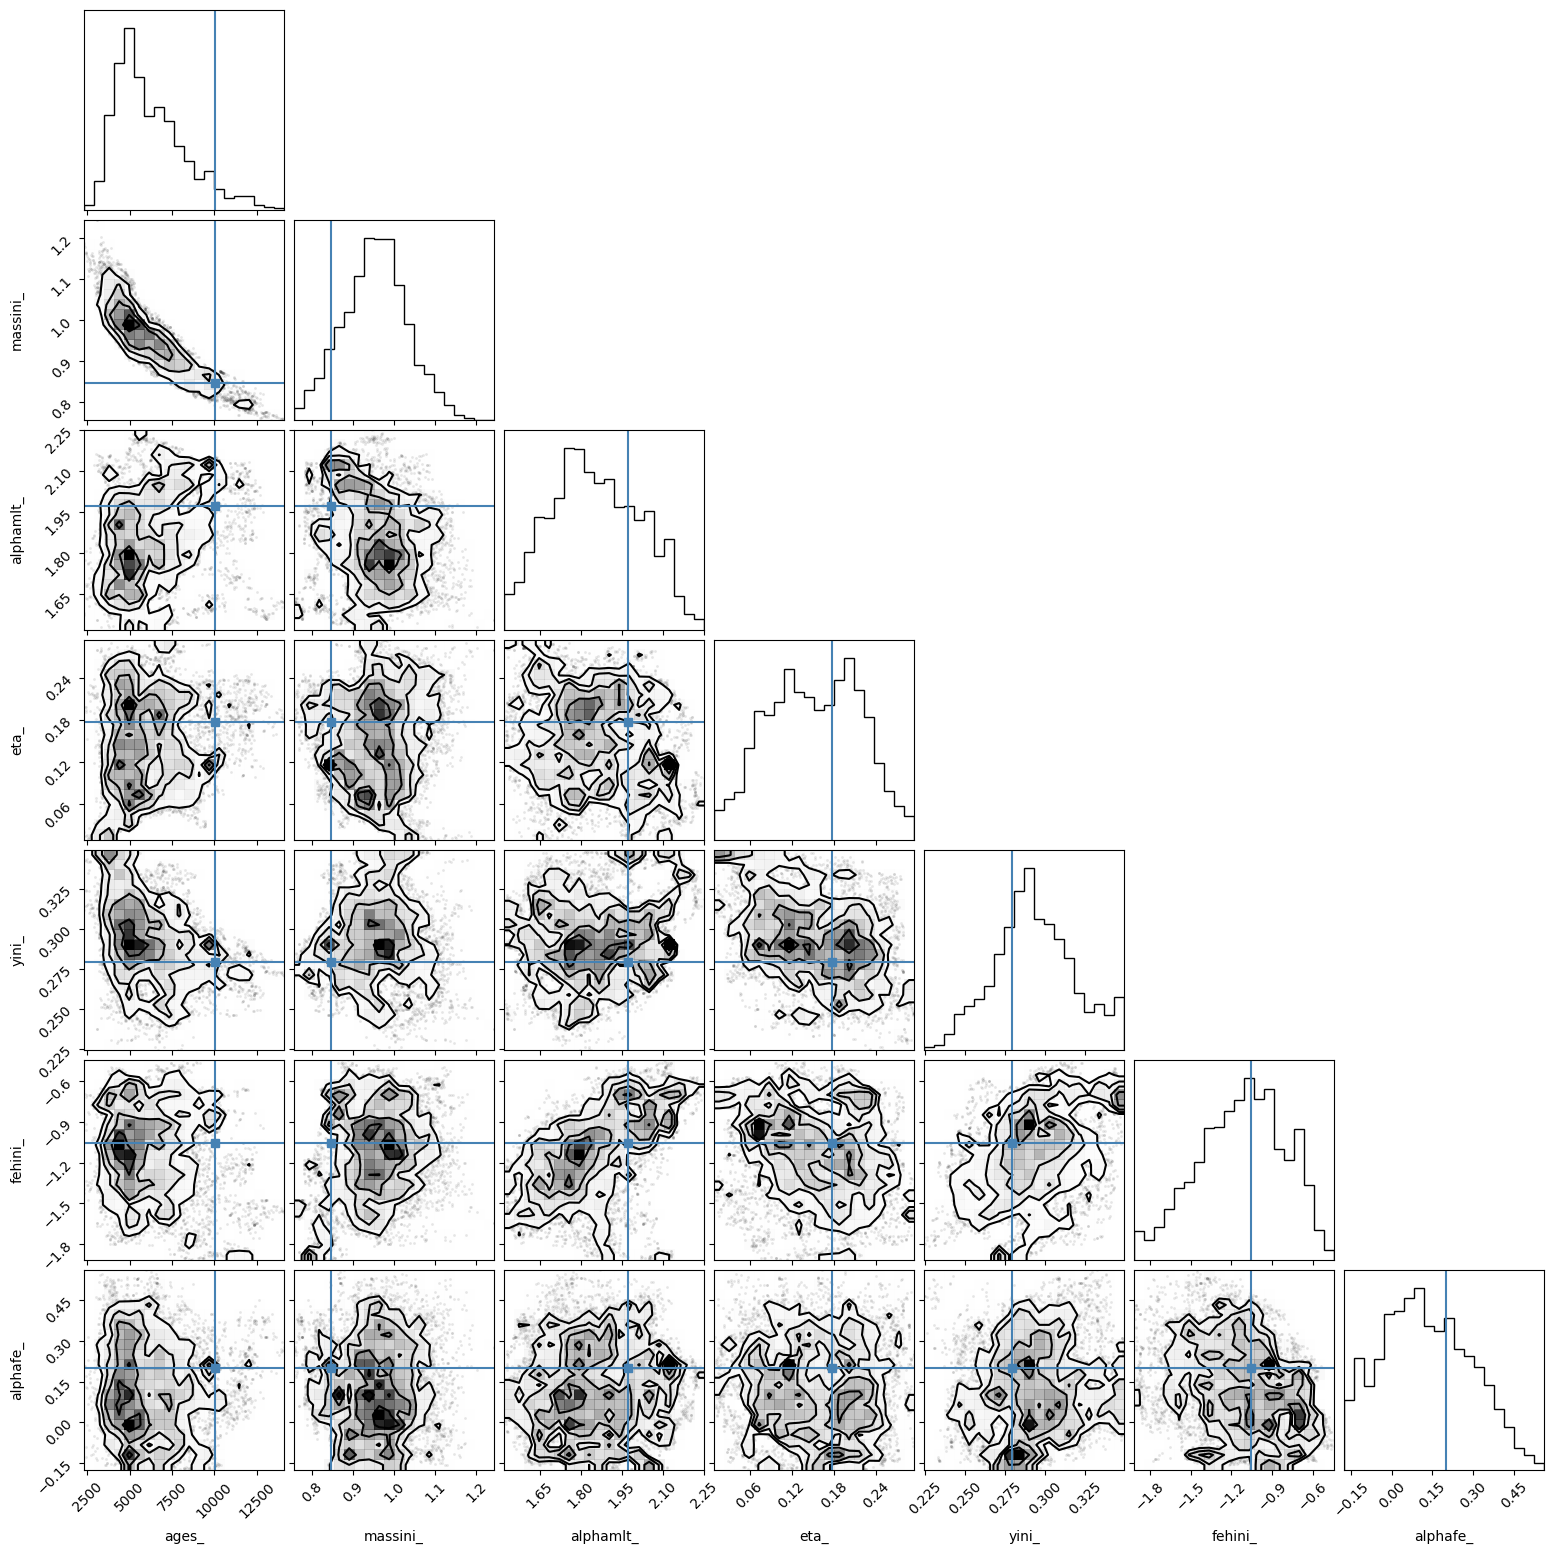

In [119]:
# Setting truth values for corner plot
truth_values = [age_07298_.item(), massini_07298[0].item(), 
                alphamlt_07298[0].item(), eta_07298[0].item(),
                yini_07298[0].item(),  fehini_07298[0].item(),
                alphafe_07298[0].item()]
print(truth_values)
import corner

corner.corner(trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             truths = truth_values);

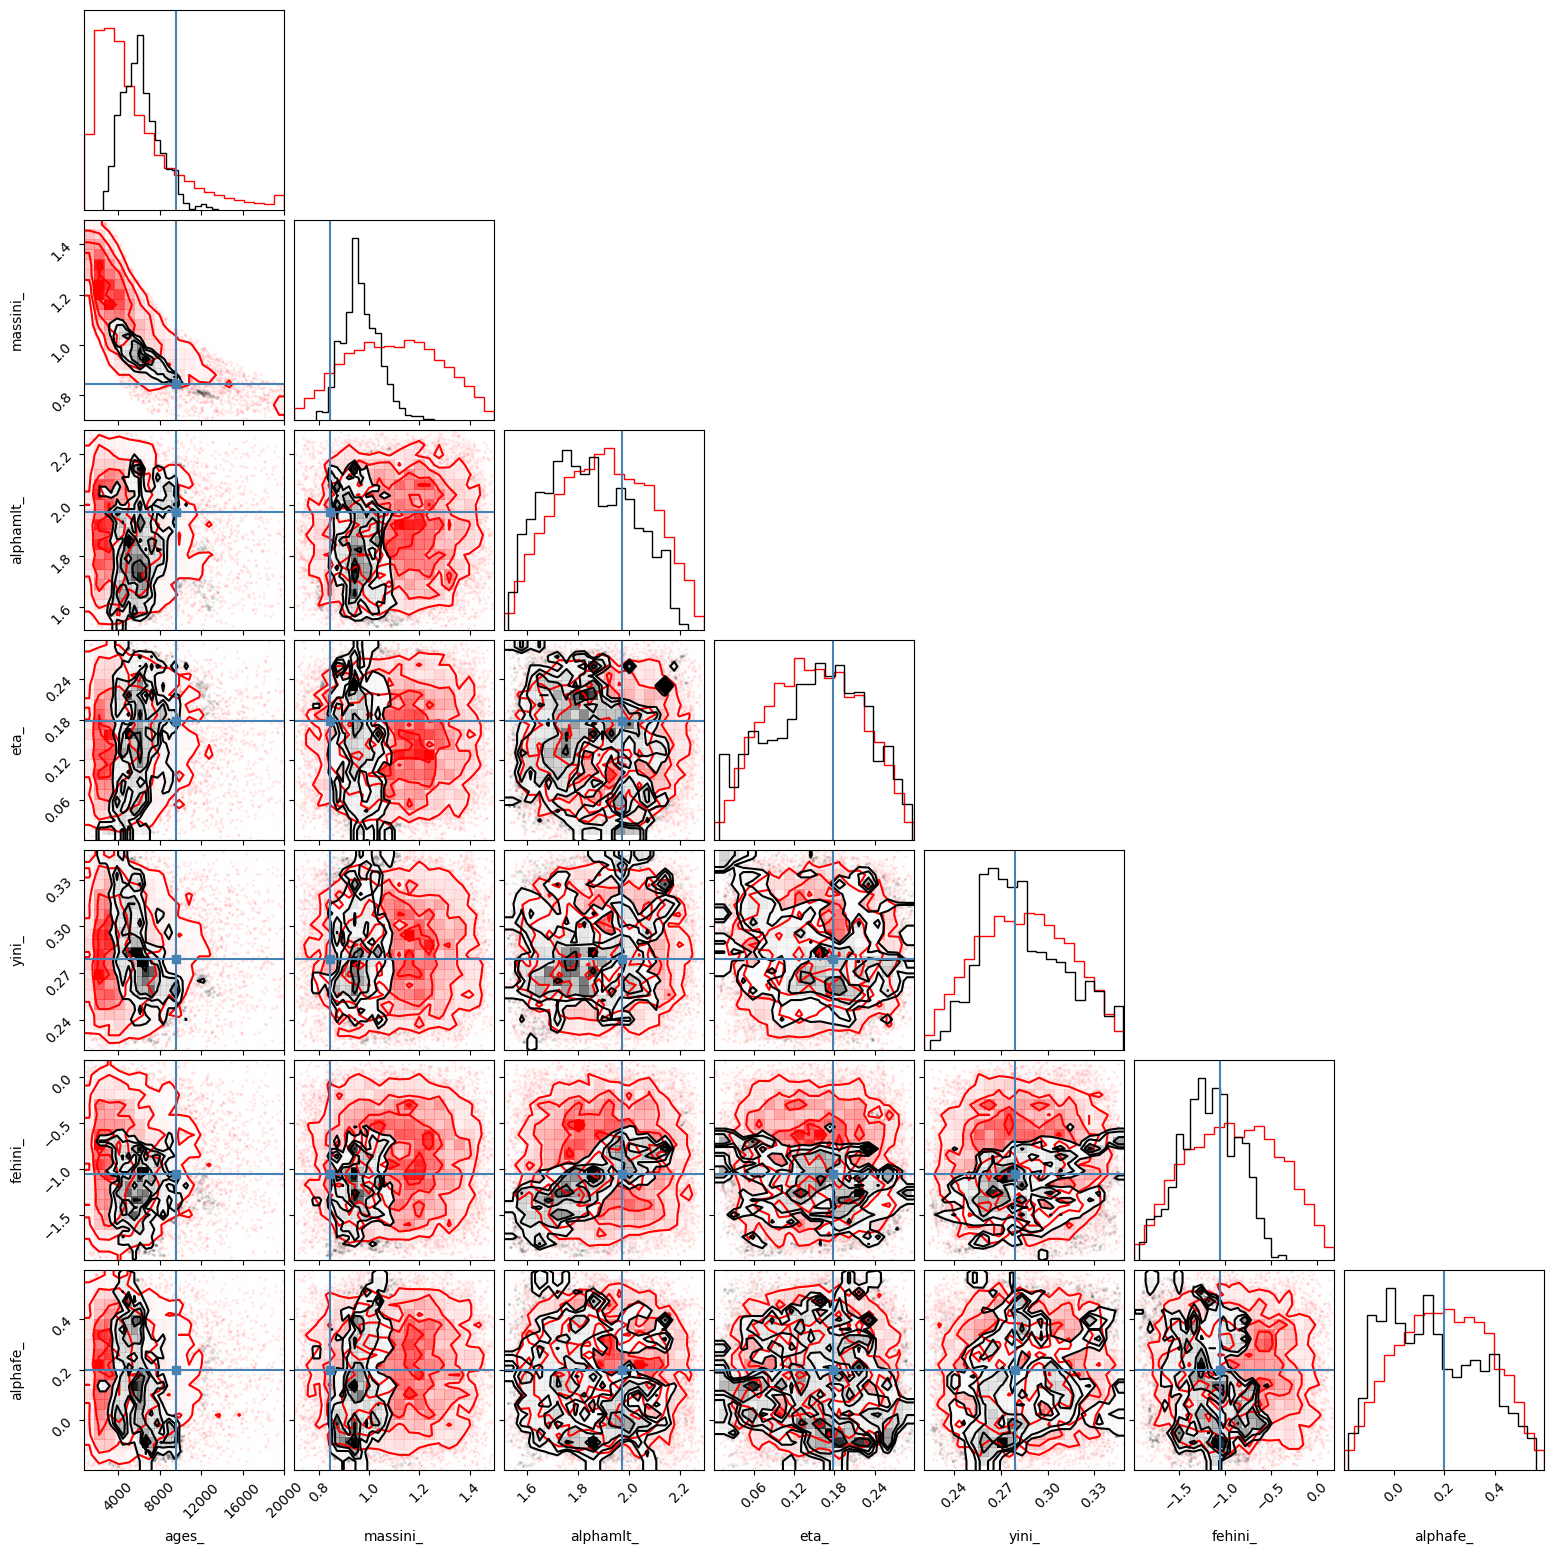

In [129]:
figure = corner.corner(prior_trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'],
              color='r');

corner.corner(trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
            fig=figure,
            truths = truth_values);
plt.show()

In [114]:
from sklearn.preprocessing import MinMaxScaler


# Extract the variables from the trace
ages_samples = trace.posterior['ages_'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()

closest_index = np.argmin(np.abs(mass_samples - massini_07298_))

length = len(age_07298)
      
ages_indices = []

for i in range(length):
    # Find the index in ages_samples closest to the current age value
    closest_index = np.argmin(np.abs(ages_samples - age_07298[i]))
    ages_indices.append(closest_index)


# Select the next `length` values after the min_age index
ages_subsample = np.sort(ages_samples[ages_indices]).reshape(-1, 1)
mass_subsample = np.full(length, mass_samples[closest_index]).reshape(-1, 1) 
mlt_subsample = np.full(length, np.mean(mlt_samples)).reshape(-1, 1)
eta_subsample = np.full(length, np.mean(eta_samples)).reshape(-1, 1) 
yini_subsample = np.full(length, np.mean(yini_samples)).reshape(-1, 1) 
fehini_subsample = np.full(length, np.mean(fehini_samples)).reshape(-1, 1) 
fe_subsample = np.full(length, np.mean(fe_samples)).reshape(-1, 1) 

epsilon = 1e-10
log10_hbm_inputs = [age_07298, mass_subsample, mlt_subsample, eta_subsample, yini_subsample] 
log10_transformed_hbm_inputs = [np.log10(np.maximum(data, epsilon)) for data in log10_hbm_inputs]

# Combine log-transformed inputs with raw `fehini` and `alpha fe`
features = np.hstack(log10_transformed_hbm_inputs + [fehini_subsample, fe_subsample])

features_numpy = np.array(features)  # Convert to numpy for scaling

features_scaled = scaler_X.transform(features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor

features_tensor = torch.FloatTensor(features_scaled)


In [115]:
print(mass_subsample[0],
mlt_subsample[0],
eta_subsample[0],
yini_subsample[0],
fehini_subsample[0],
fe_subsample[0])

print(massini_07298_, alphamlt_07298_, eta_07298_, yini_07298_, fehini_07298_, alphafe_07298_)

[0.81790006] [1.8437924] [0.14122967] [0.29016283] [-1.1091567] [0.13596411]
[0.845] [1.97304687] [0.17797852] [0.27909668] [-1.05361328] [0.2]


<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Dell\AppData\Local\Temp\ipykernel_59328\2887813514.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
C:\Users\Dell\AppData\Local\Temp\ipykernel_59328\2887813514.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(f"Log Luminosity ($\log(L_\odot)$)")


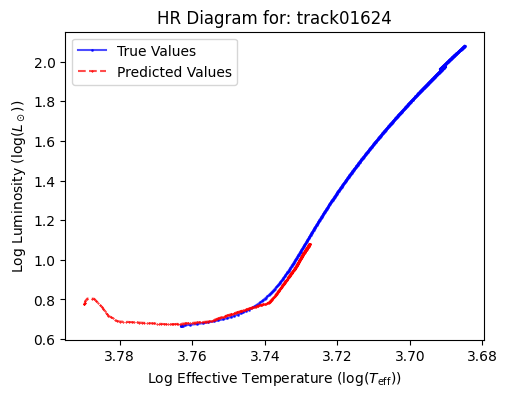

In [116]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm1 = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
hbm_luminosity = 10**predictions_hbm1[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_07298)
log_actual_luminosity = np.log10(luminosity_07298)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(5.4, 4))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel(f"Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()